# Pipeline Diagram
Make some figures to show a cartoon of our pipeline diagram

In [302]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import astropy.time
import astropy.units as u
from astropy.visualization import ImageNormalize,AsinhStretch,SqrtStretch
from astropy.coordinates import SkyCoord
from sunpy.map import Map,GenericMap
from sunpy.util import MetaDict
import sunpy.coordinates
import sunpy.sun.constants as const
import synthesizAR
import synthesizAR.extrapolate
from synthesizAR.interfaces import EbtelInterface
from synthesizAR.instruments import InstrumentSDOAIA
import yt
import distributed

%matplotlib inline

In [307]:
client = distributed.Client()

In [308]:
client

Client Scheduler: tcp://127.0.0.1:34664 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


In [306]:
client.close()

First, plot the magnetogram. We'll make a fake one

In [2]:
def make_synthetic_map(xrange, yrange, shape, spots):
    # Setup array
    delta_x = xrange[1] - xrange[0]
    delta_y = yrange[1] - yrange[0]
    dx = delta_x/arr_grid_shape[0]
    dy = delta_y/arr_grid_shape[1]
    data = np.zeros(shape)
    xphysical, yphysical = np.meshgrid(np.arange(shape[0])*dx, np.arange(shape[1])*dy)
    # Add sunspots
    for spot in spots:
        if spot[0].unit is u.percent:
            pos = u.Quantity([spot[0][0].value/100.*delta_x + xrange[0],
                              spot[0][1].value/100.*delta_y + yrange[0]])
        else:
            pos = spot[0]
        if spot[1].unit is u.percent:
            sigma = spot[1].value/100.*delta_x
        else:
            sigma = spot[1]
        a_max   = spot[2].value
        xc_2 = (xphysical - pos[0] + xrange[0]).value**2.0
        yc_2 = (yphysical - pos[1] + yrange[0]).value**2.0
        data += a_max * np.exp( - ( (xc_2 + yc_2) / (2 * sigma.value**2)) )
        
    # Build metadata
    time_now = astropy.time.Time.now()
    observer = sunpy.coordinates.ephemeris.get_earth(time=time_now)
    meta = MetaDict({
        'telescop': 'fake_telescope',
        'instrume': 'fake_mag_imager',
        'detector': 'fake_detector',
        'bunit': 'Gauss',
        'ctype1': 'HPLN-TAN',
        'ctype2': 'HPLT-TAN',
        'hgln_obs': observer.lon.to(u.deg).value,
        'hglt_obs': observer.lat.to(u.deg).value,
        'cunit1': 'arcsec',
        'cunit2': 'arcsec',
        'crpix1': (shape[0] + 1)/2.,
        'crpix2': (shape[1] + 1)/2.,
        'cdelt1': delta_x.to(u.arcsec).value/shape[0],
        'cdelt2': delta_y.to(u.arcsec).value/shape[1],
        'crval1': ((xrange[0] + xrange[1])/2.).value,
        'crval2': ((yrange[0] + yrange[1])/2.).value,
        'dsun_obs': observer.radius.to(u.m).value,
        'dsun_ref': observer.radius.to(u.m).value,
        'rsun_ref': const.radius.to(u.m).value,
        'rsun_obs': ((const.radius/observer.radius).decompose() * u.radian).to(u.arcsec).value,
        't_obs': time_now.iso,
        'date-obs': time_now.iso,
    })
        
    plot_settings = {'cmap': 'hmimag',
                     'norm': matplotlib.colors.Normalize(vmin=-1.5e3, vmax=1.5e3)}
        
    return GenericMap(data, meta, plot_settings=plot_settings)

In [228]:
arr_grid_shape = [ 300, 300]
width_x,width_y = 300 * u.arcsec, 300 * u.arcsec
left_corner_x, left_corner_y = -150 * u.arcsec, -150 * u.arcsec
xrange = u.Quantity((left_corner_x, left_corner_x + width_x))
yrange = u.Quantity((left_corner_y, left_corner_y + width_y))
spots = [
    ( u.Quantity([65,50],u.percent), 3.5*u.percent,  1e3*u.Gauss),
    ( u.Quantity([35,50],u.percent), 3.5*u.percent,  -1e3*u.Gauss),
    #( u.Quantity([35,35],u.percent), 2*u.percent, -1e3*u.Gauss),
    #( u.Quantity([65,65],u.percent), 2*u.percent, -1e3*u.Gauss),
]
magnetogram = make_synthetic_map(xrange,yrange,arr_grid_shape,spots)

In [369]:
# Make a custom colormap to get good reds and blues but also have white in the middle
rwb_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'rwb_nice', [(215/255, 48/255, 31/255), (1, 1, 1), (5/255, 112/255, 176/255)], N=1000)

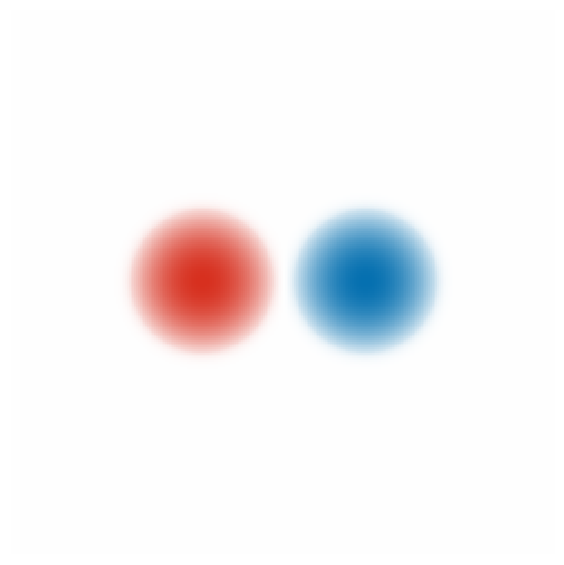

In [370]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=magnetogram)
magnetogram.plot(axes=ax,annotate=False,title=False,cmap=rwb_cmap,
                 norm=matplotlib.colors.SymLogNorm(1,vmin=-1e3,vmax=1e3))
lon,lat = ax.coords[0],ax.coords[1]
lon.set_ticklabel_visible(False)
lat.set_ticklabel_visible(False)
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
ax.grid(alpha=0)
lon.frame.set_linewidth(0.)
lat.frame.set_linewidth(0.)
fig.savefig('../img/magnetogram_diagram.png',format='png',dpi=300,bbox_inches='tight')

Then plot the field extrapolation

In [5]:
shape_z = 100*u.pixel
width_z = 0.3*const.radius

In [6]:
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram,width_z,shape_z)

In [7]:
B_field = extrapolator.extrapolate()

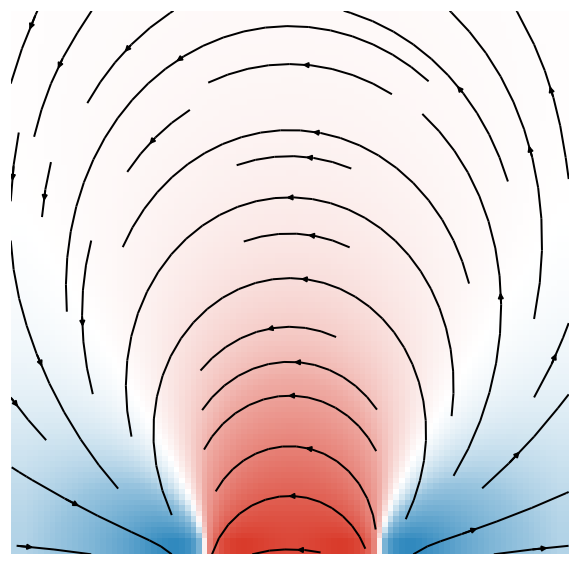

In [373]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax1_grid, ax2_grid = np.meshgrid(np.linspace(-1, 1, B_field.x.shape[1]),
                                 np.linspace(-1, 1, B_field.x.shape[0]))
b_sum = B_field.x[:,:,:].sum(axis=0).value.T
b_stream_1 = B_field.x[:,:,:].sum(axis=0).value.T
b_stream_2 = B_field.z[:,:,:].sum(axis=0).value.T
im = ax.pcolormesh(ax1_grid,ax2_grid,b_sum,
              cmap=rwb_cmap,
              norm=matplotlib.colors.SymLogNorm(500,vmin=-5e3,vmax=5e3)
             )
ax.streamplot(ax1_grid[0, :], ax2_grid[:, 0], b_stream_1, b_stream_2,
              color='k', density=0.5,linewidth=2)
ax.tick_params(axis='both',which='both',
               bottom='off',top='off',left='off',right='off',
               labelbottom='off',labeltop='off',labelleft='off',labelright='off')
#fig.colorbar(im)
ax.axis('off')
fig.savefig('../img/extrapolation_diagram.png',format='png',dpi=300,bbox_inches='tight')

Then plot a few sample fieldlines

In [236]:
fieldlines = extrapolator.trace_fieldlines(B_field,500,loop_length_range=[10,250]*u.Mm,close_threshold=0.05,mask_threshold=0.1,direction=1)

yt : [INFO     ] 2018-05-11 18:07:27,472 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-11 18:07:27,472 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-05-11 18:07:27,473 Parameters: domain_left_edge          = [-1.09358865e+10 -1.09376905e+10  0.00000000e+00]
yt : [INFO     ] 2018-05-11 18:07:27,473 Parameters: domain_right_edge         = [1.09414436e+10 1.09432485e+10 2.08652400e+10]
yt : [INFO     ] 2018-05-11 18:07:27,474 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-05-11 18:07:28,165 AMRKDTree rebuilt, Final Volume: 9.988118e+30
Streamlining: 100%|██████████| 500/500 [00:01<00:00, 368.00it/s]
yt : [INFO     ] 2018-05-11 18:07:30,370 AMRKDTree rebuilt, Final Volume: 9.988118e+30
Streamlining: 100%|██████████| 139/139 [00:00<00:00, 337.00it/s]
yt : [INFO     ] 2018-05-11 18:07:31,235 AMRKDTree rebuilt, Final Volume: 9.988118e+30
Streamlining: 100%|██████████| 34/34 [00:00<00:00, 310.00it/s]
yt : [INFO     ] 2018-

FloatProgress(value=0.0)

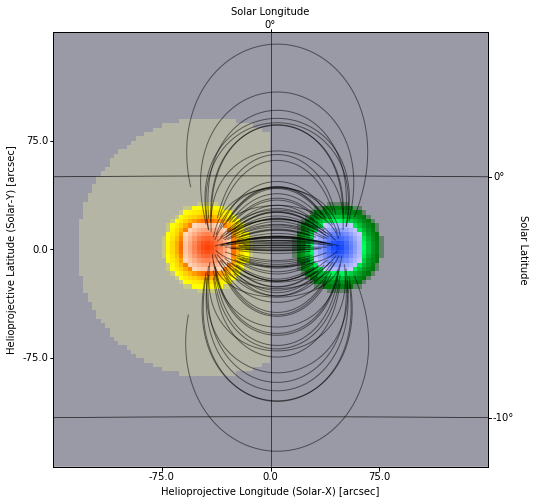

In [237]:
extrapolator.peek(fieldlines,line_frequency=5)

In [238]:
active_region = synthesizAR.Field(magnetogram,fieldlines)

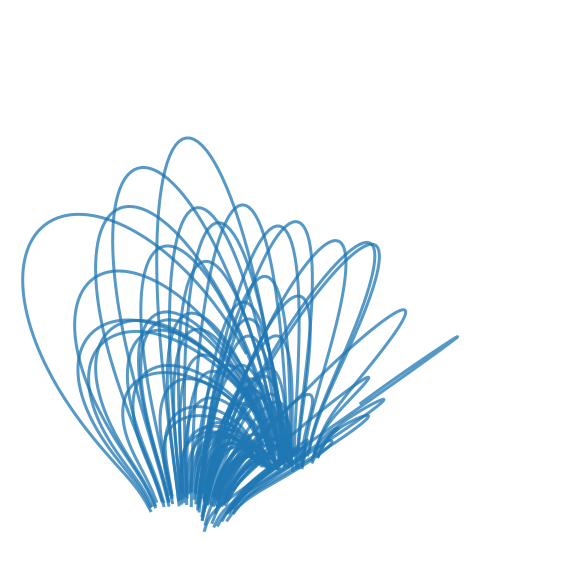

In [254]:
#x_offset = 10*u.Mm
#y_offset = 10*u.Mm
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_axis_off()
for i,l in enumerate(active_region.loops[::5]):
    #s = l.field_aligned_coordinate/l.full_length
    #r = np.sqrt((l.coordinates**2).sum(axis=1))
    #r = r#/r.max()
    ax.plot(l.coordinates[:,1].to(u.Mm),l.coordinates[:,2].to(u.Mm),l.coordinates[:,0].to(u.Mm), color='C0',lw=3,alpha=0.75)
#ax.tick_params(axis='both',which='both',
#               bottom='off',top='off',left='off',right='off',
#               labelbottom='off',labeltop='off',labelleft='off',labelright='off')
ax.set_ylim(-105,20)
ax.set_zlim(700,735)
ax.set_xlim(-105,20)
ax.view_init(35,40)
#ax.set_aspect('auto','datalim')
fig.savefig('../img/fieldlines_diagram.png',format='png',dpi=300,bbox_inches='tight',transparent=True)

We'll configure some EBTEL runs for this simple model.

In [290]:
class RandomNanoflares(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        
    def calculate_event_properties(self,loop):
        self.number_events = self.heating_options['number_events']
        start_time = np.random.uniform(low=0, high=self.base_config['total_time'] - self.heating_options['duration'],size=self.number_events)
        max_energy = (self.heating_options['stress_level'] * loop.field_strength.mean().value)**2/(8.*np.pi)/self.number_events
        return {'magnitude': np.array(self.number_events*[max_energy/(self.heating_options['duration']/2.)]),
                'rise_start': start_time,
                'rise_end': start_time + self.heating_options['duration']/2,
                'decay_start': start_time + self.heating_options['duration']/2,
                'decay_end': start_time + self.heating_options['duration'],}

In [291]:
heating_options = {
    'duration':200.0,
    'stress_level':0.3,
    'number_events':30,
}
heating_model = RandomNanoflares(heating_options)

In [292]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 2e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [293]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '../data/dipole_example/hydro_config/',
                                 '../data/dipole_example/hydro_results/')

In [294]:
active_region.configure_loop_simulations(ebtel_interface,)

FloatProgress(value=0.0)

In [295]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [296]:
for loop in active_region.loops:
    ebtel_runner(loop)

In [297]:
active_region.load_loop_simulations(ebtel_interface,'../data/dipole_example/loop_parameters.h5')

FloatProgress(value=0.0)

Then plot a few sample temperature and density curves

In [300]:
loop_num = np.random.randint(0,high=len(active_region.loops),size=1)[0]
loop = active_region.loops[loop_num]

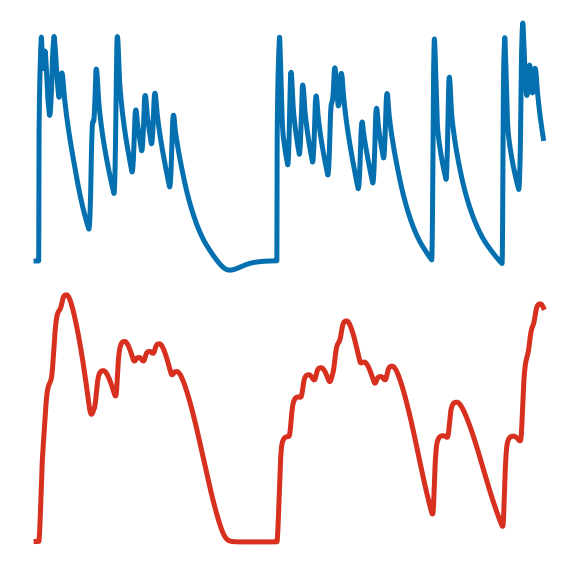

In [382]:
fig,axes = plt.subplots(2,1,figsize=(10,10),sharex=True,)
# Temperature 
axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),
             color=(5/255, 112/255, 176/255),
             lw=5,)
axes[0].tick_params(axis='both',which='both',
               bottom='off',top='off',left='off',right='off',
               labelbottom='off',labeltop='off',labelleft='off',labelright='off')
#axes[0].spines['right'].set_visible(False)
#axes[0].spines['top'].set_visible(False)
#axes[0].spines['bottom'].set_visible(False)
#axes[0].spines['left'].set_linewidth(3)
# Density
axes[1].plot(loop.time,loop.density[:,0]/1e9,
             color=(215/255, 48/255, 31/255),
             lw=5)
axes[1].tick_params(axis='both',which='both',
               bottom='off',top='off',left='off',right='off',
               labelbottom='off',labeltop='off',labelleft='off',labelright='off')
#axes[1].spines['top'].set_visible(False)
#axes[1].spines['right'].set_visible(False)
#axes[1].spines['left'].set_linewidth(3)
#axes[1].spines['bottom'].set_linewidth(3)
plt.subplots_adjust(hspace=0)
#axes[0].set_xlim(1e4,2e4)
axes[0].axis('off')
axes[1].axis('off')
fig.savefig('../img/profiles_diagram.png',format='png',dpi=300,bbox_inches='tight',transparent=True)

Now, synthesize an observation and plot an image.

In [303]:
aia = InstrumentSDOAIA([9.5e3,10.5e3]*u.s)

In [309]:
observer = synthesizAR.Observer(active_region, [aia], parallel=True)

In [310]:
observer.build_detector_files('../data/dipole_example/',ds=0.25*u.Mm,)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [311]:
flat_futures = observer.flatten_detector_counts()

In [312]:
bin_futures = observer.bin_detector_counts('../data/dipole_example/')

Then plot a synthesized image

In [350]:
m = Map('../data/dipole_example/SDO_AIA/94/map_t000000.fits')
m = m.submap(
    SkyCoord(-70*u.arcsec,-75*u.arcsec,frame=m.coordinate_frame),
    SkyCoord(80*u.arcsec,75*u.arcsec,frame=m.coordinate_frame),
)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


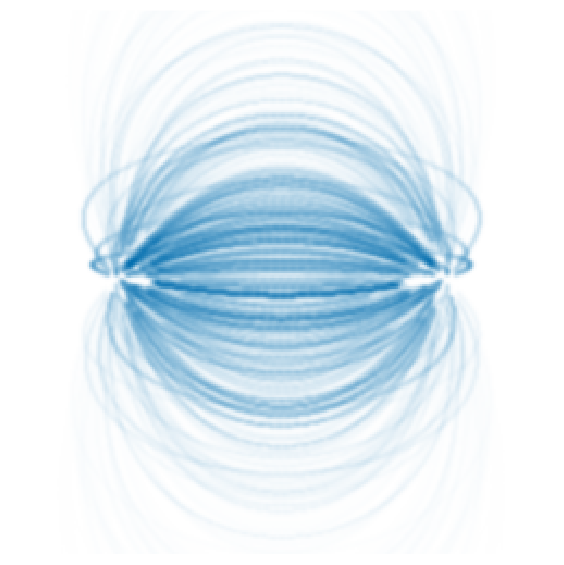

In [380]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=m)
blues_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Blues_nice',
    [(1,1,1),(5/255,112/255,176/255)],
    1000,
)
m.plot(axes=ax,annotate=False,title=False,
       norm=ImageNormalize(vmin=0,vmax=5e0,stretch=AsinhStretch(0.1)),
       cmap=blues_cmap,
      )
ax.grid(alpha=0)
lon,lat = ax.coords[0],ax.coords[1]
lon.set_ticklabel_visible(False)
lat.set_ticklabel_visible(False)
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
lon.frame.set_linewidth(0.)
lat.frame.set_linewidth(0.)
fig.savefig('../img/aia_diagram.png',format='png',dpi=300,bbox_inches='tight')